In [414]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from utils.common_plot_tetha import plot_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as IPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, fbeta_score
from sklearn.feature_selection import SelectFromModel
from pprint import pprint
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings("ignore") 
from sklearn import set_config
set_config(display='diagram')

# 1. Read Data

In [322]:
df = pd.read_csv('bank+marketing/bank_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                41188 non-null  int64  
 1   job                41188 non-null  object 
 2   marital            41188 non-null  object 
 3   education          41188 non-null  object 
 4   default            41188 non-null  object 
 5   housing            41188 non-null  object 
 6   loan               41188 non-null  object 
 7   contact            41188 non-null  object 
 8   month              41188 non-null  object 
 9   duration           41188 non-null  int64  
 10  campaign           41188 non-null  int64  
 11  previous           41188 non-null  int64  
 12  poutcome           41188 non-null  object 
 13  emp.var.rate       41188 non-null  float64
 14  cons.price.idx     41188 non-null  float64
 15  cons.conf.idx      41188 non-null  float64
 16  euribor3m          411

# 2. Train Test Split

In [323]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['balance_transform','y','previous','poutcome','default'], axis=1), df['y'], test_size = 0.3, random_state = 42)

In [340]:
obj_cat = X_train.select_dtypes(include=['object'])
obj_cat.columns

Index(['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month'], dtype='object')

In [341]:
num_cat = X_train.select_dtypes(exclude=['object'])
num_cat.columns

Index(['age', 'duration', 'campaign', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'balance', 'day'],
      dtype='object')

# 3. Column Transformation
- OneHotEncoder for 'job','marital', 'contact', 'default', 'housing', 'loan', 'contact', 'month','poutcome'
- OrdinalEncoder for education

In [324]:
education_categories = [['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'university.degree','professional.course']]
one_hot_encoding_features = ['job', 'marital', 'housing', 'loan', 'contact', 'month']

transformer = make_column_transformer(    
    (OneHotEncoder(),one_hot_encoding_features),
    (OrdinalEncoder(categories=education_categories, unknown_value=-1, handle_unknown='use_encoded_value'),['education']),
    remainder = StandardScaler()
)

# 4. Pipeline for EDA

In [325]:
pipeline = Pipeline([
    ('transformer', transformer),     
    ('classifier', KNeighborsClassifier())
])

## 4.1 Plain Vanila fitting

In [326]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['job', 'marital', 'housing',
                                                   'loan', 'contact',
                                                   'month']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                              'high.school',
                                                                              'university.degree',
                                                                              'professional.course']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['education'])])),
                ('classifier', KNeighborsClassifier())])

In [327]:
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)

In [328]:
print(f'Training Accuracy: {train_acc: .2f}')
print(f'Test Accuracy:     {test_acc: .2f}')

Training Accuracy:  0.93
Test Accuracy:      0.90


<div class="alert alert-block alert-warning">
The purpose of EDA is to get the rough parameters for GridSearch. 
</div>

## 4.2. EDA

In [329]:
train_accuracies, test_accuracies = [],[]
for n  in range(4,20):
    pipeline = pipeline = Pipeline([
                ('transformer', transformer),     
                ('classifier', KNeighborsClassifier(n_neighbors=n))
    ])    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate and collect accuracies
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))

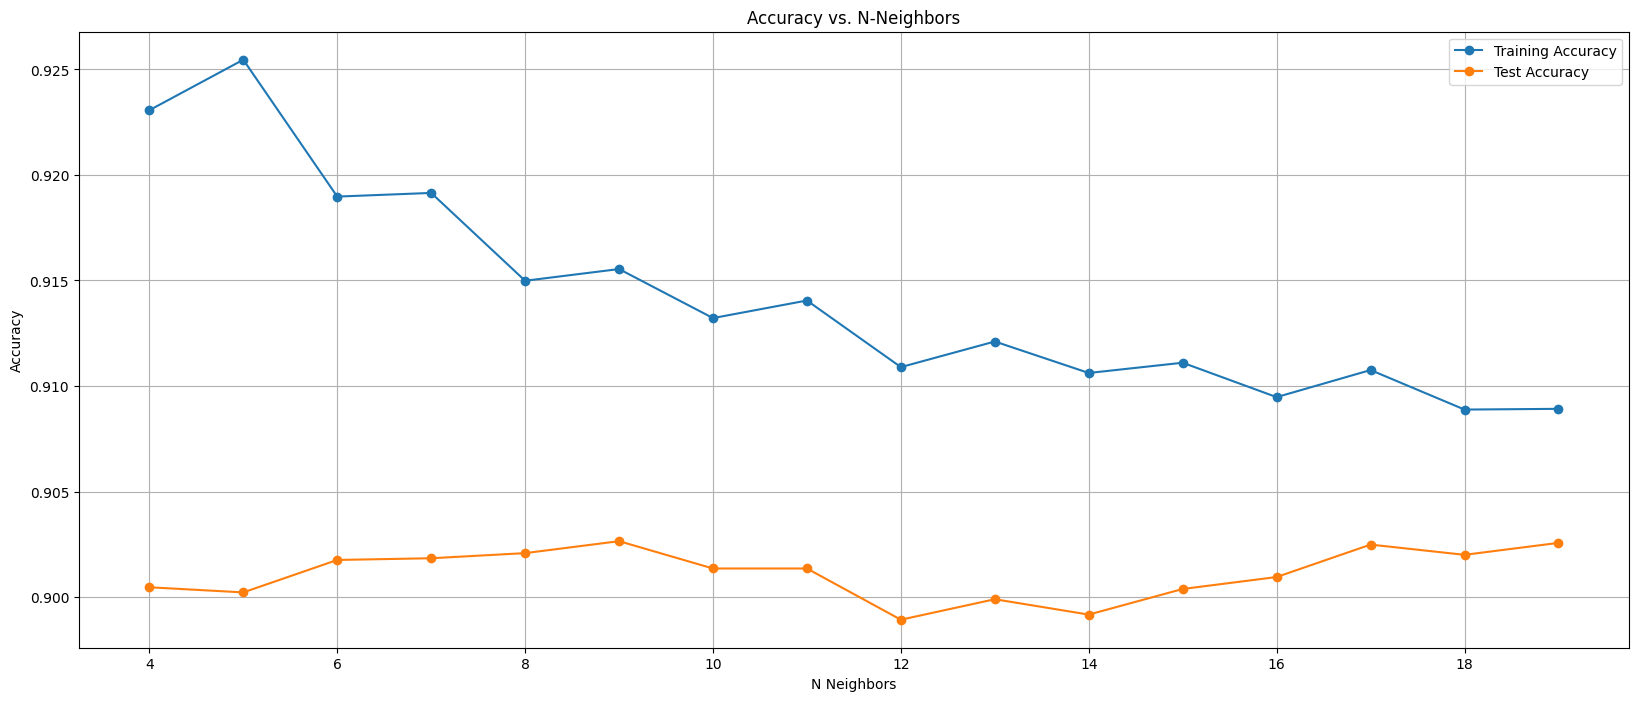

In [330]:
plt.figure(figsize=(20, 8))
plt.plot(range(4,20), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(4,20), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('N Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. N-Neighbors')
plt.legend()
plt.grid(True)
plt.show()

In [331]:
def precision_thresh(predict_probs, y_test, thresh):
    preds = np.where(predict_probs >= thresh, 'yes', 'no')    
    return precision_score(y_test, preds, pos_label='yes')

def recall_thresh(predict_probs, y_test, thresh):
    preds = np.where(predict_probs >= thresh, 'yes', 'no')
    return recall_score(y_test, preds, pos_label='yes')

In [332]:
knn_pipe = Pipeline([('transformer', transformer), 
                     ('classifier', KNeighborsClassifier(n_neighbors = 17))])
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['job', 'marital', 'housing',
                                                   'loan', 'contact',
                                                   'month']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                              'high.school',
                                                                              'university.degree',
                                                                              'professional.course']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['education'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=17))])

In [333]:
test_predictions = knn_pipe.predict_proba(X_test)
print(precision_thresh(test_predictions[:, 1], y_test, 0.1))
print(precision_thresh(test_predictions[:, 1], y_test, 0.9))

0.38708699605941194
1.0


In [334]:
thresholds = np.arange(0, 1, .05)
results_df = pd.DataFrame({'threshold': thresholds, 
                           'precision': [precision_thresh(test_predictions[:, 1], y_test, i) for i in thresholds],
                           'recall': [recall_thresh(test_predictions[:, 1], y_test, i) for i in thresholds]})

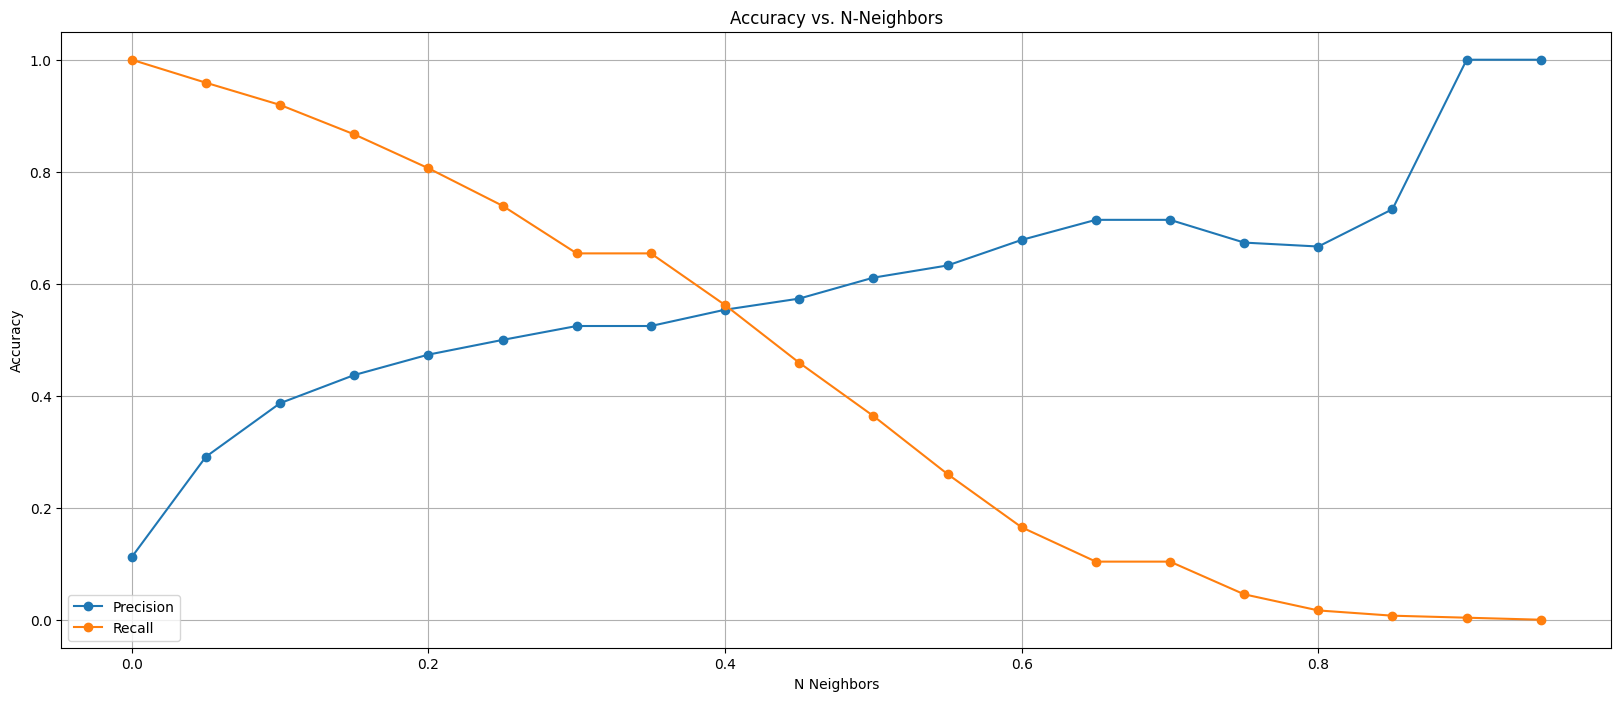

In [335]:
plt.figure(figsize=(20, 8))
plt.plot(thresholds, results_df['precision'], label='Precision', marker='o')
plt.plot(thresholds, results_df['recall'], label='Recall', marker='o')
plt.xlabel('N Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. N-Neighbors')
plt.legend()
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<b>Pipeline 1</b><br>
First Pipeline, with GridSearchCV, with parameters `n_neighbors` range determined from above EDA
</div>

# 5. Pipeline - 1

In [365]:
pipeline1 = Pipeline([
    ('transform', transformer),     
    ('model', KNeighborsClassifier())
])

## 5.1 GridSearchCV

In [366]:
params1 = {
    'model__n_neighbors': list(range(11, 42, 2))
}

In [367]:
cv1 = GridSearchCV(pipeline1, param_grid=params1, n_jobs=-1, verbose=True, scoring=make_scorer(fbeta_score, beta=2, pos_label='yes'))

## 5.2. Fitting the KNeighborsClassifier Model

In [368]:
cv1.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'university.degree',
                                                                                                     'professional.course']],
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['education'])])),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [11, 13, 15, 17, 19, 21, 23, 25,
                                                27, 29, 31, 33, 35, 37, 39,
                                                41]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2, pos_label=yes),
             verbose=True)

In [369]:
pprint(cv1.best_params_)

{'model__n_neighbors': 11}


## 5.3. Predictions

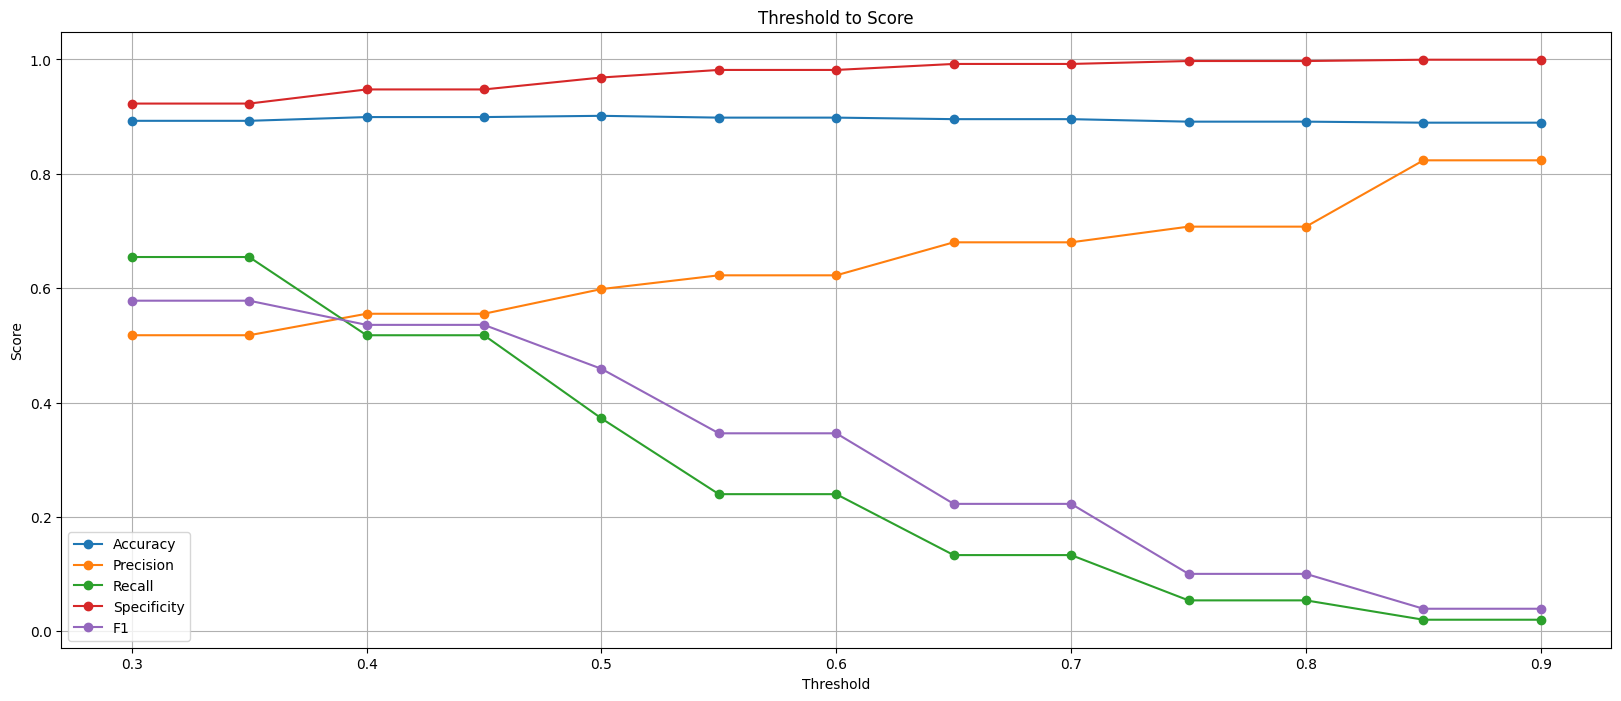

In [416]:
plot_model(cv1, X_test, y_test)

<div class="alert alert-block alert-warning">
At roughly 0.45 threshold, we wee that F1 Score and Recall Score starts to decrease. Thus same was picked for threshold.
</div>

In [297]:
# y_pred_1 = cv1.predict(X_test)
probs = cv1.predict_proba(X_test)
y_pred_1 = np.where(probs[:, 1] >= 0.45,  'yes','no')

## 5.4. Scoring

In [298]:
accuracy = accuracy_score(y_test, y_pred_1)
print("Accuracy:", accuracy)

Accuracy: 0.899166464352189


In [299]:
p_score = precision_score(y_test, y_pred_1,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.5552123552123552


In [300]:
r_score = recall_score(y_test, y_pred_1,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.5176385889128869


In [301]:
f_1_score = f1_score(y_test, y_pred_1, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.5357675111773472


In [302]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_1).ravel()
tn, fp, fn, tp

(np.int64(10392), np.int64(576), np.int64(670), np.int64(719))

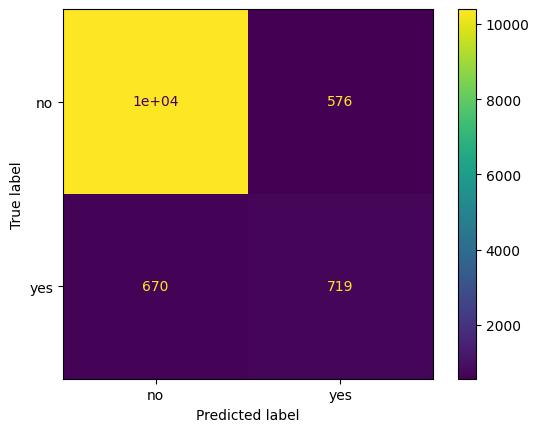

In [303]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1);

<div class="alert alert-block alert-info">
<b>Pipeline 2</b><br>
- Grid Search with Feature Selection
</div>

# 6. Pipeline - 2

In [304]:
pipeline2 = Pipeline([
    ('transform', transformer), 
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(random_state=43, max_iter = 1000, C= 0.1, penalty= 'l1',solver= 'liblinear'))),
    ('model', KNeighborsClassifier())
])

## 6.1 GridSearchCV

In [305]:
params2 = {
    'model__n_neighbors': list(range(11, 42, 2))
}

In [306]:
cv2 = GridSearchCV(pipeline2, param_grid=params2, n_jobs=-1, verbose=True, scoring=make_scorer(fbeta_score, beta=2, pos_label='yes'))

## 6.2. Fitting the KNeighborsClassifier Model

In [307]:
cv2.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'university.degree',
                                                                                                     'professional.course']],
                                                                                        ha...
                                       ('feature_selection',
                                        SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                                                     max_iter=1000,
                                                                                     penalty='l1',
                                                                                     random_state=43,
                                                                                     solver='liblinear'))),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [11, 13, 15, 17, 19, 21, 23, 25,
                                                27, 29, 31, 33, 35, 37, 39,
                                                41]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2, pos_label=yes),
             verbose=True)

In [308]:
pprint(cv2.best_params_)

{'model__n_neighbors': 11}


## 6.3. Predictions

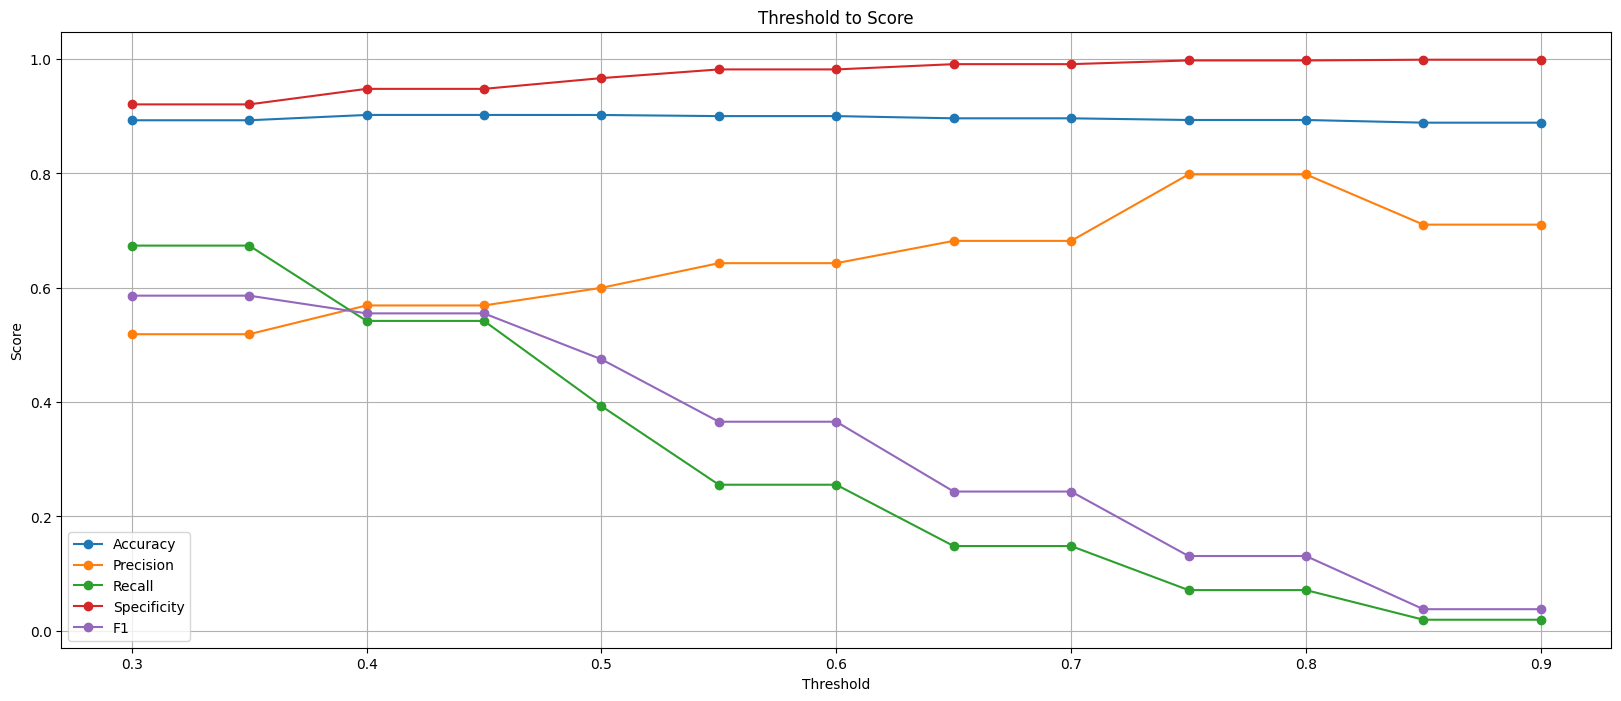

In [417]:
plot_model(cv2, X_test, y_test)

<div class="alert alert-block alert-warning">
At roughly 0.45 threshold, we wee that F1 Score and Recall Score starts to decrease. Thus same was picked for threshold.
</div>

In [371]:
probs = cv2.predict_proba(X_test)
y_pred_2 = np.where(probs[:, 1] >= 0.45,  'yes','no')

## 6.4. Scoring

In [372]:
accuracy = accuracy_score(y_test, y_pred_2)
print("Accuracy:", accuracy)

Accuracy: 0.9024034959941734


In [373]:
p_score = precision_score(y_test, y_pred_2,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.5691609977324263


In [313]:
r_score = recall_score(y_test, y_pred_2,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.5421166306695464


In [314]:
f_1_score = f1_score(y_test, y_pred_2, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.5553097345132744


In [315]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_2).ravel()
tn, fp, fn, tp

(np.int64(10398), np.int64(570), np.int64(636), np.int64(753))

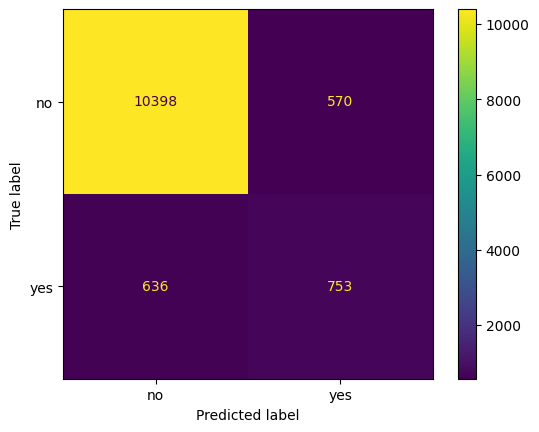

In [374]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2, values_format='d');

<div class="alert alert-block alert-info">
    <b>Pipeline 3</b><br>
    - SMOTETomek was used resampling the minority class, as the dataset is unbalanced <br>
    - Followed by GridSearch and Feature Selection
</div>

# 7. Pipeline - 3

In [351]:
pipeline3 = IPipeline([
    ('transform', transformer), 
    ('SMOTET', SMOTETomek(sampling_strategy = 'minority', random_state=42)),
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(random_state=43, max_iter = 1000, C= 0.1, penalty= 'l1',solver= 'liblinear'))),
    ('model', KNeighborsClassifier())
])

## 7.1 GridSearchCV

In [352]:
params3 = {
    'model__n_neighbors': list(range(11, 42, 2))
}

In [353]:
cv3 = GridSearchCV(pipeline3, param_grid=params3, n_jobs=-1, verbose=True, scoring=make_scorer(fbeta_score, beta=2, pos_label='yes'), error_score='raise')

## 7.2. Fitting the KNeighborsClassifier Model

In [354]:
cv3.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'university.degree',
                                                                                                     'profe...
                                       ('feature_selection',
                                        SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                                                     max_iter=1000,
                                                                                     penalty='l1',
                                                                                     random_state=43,
                                                                                     solver='liblinear'))),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [11, 13, 15, 17, 19, 21, 23, 25,
                                                27, 29, 31, 33, 35, 37, 39,
                                                41]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2, pos_label=yes),
             verbose=True)

In [355]:
pprint(cv3.best_params_)

{'model__n_neighbors': 41}


## 7.3. Predictions

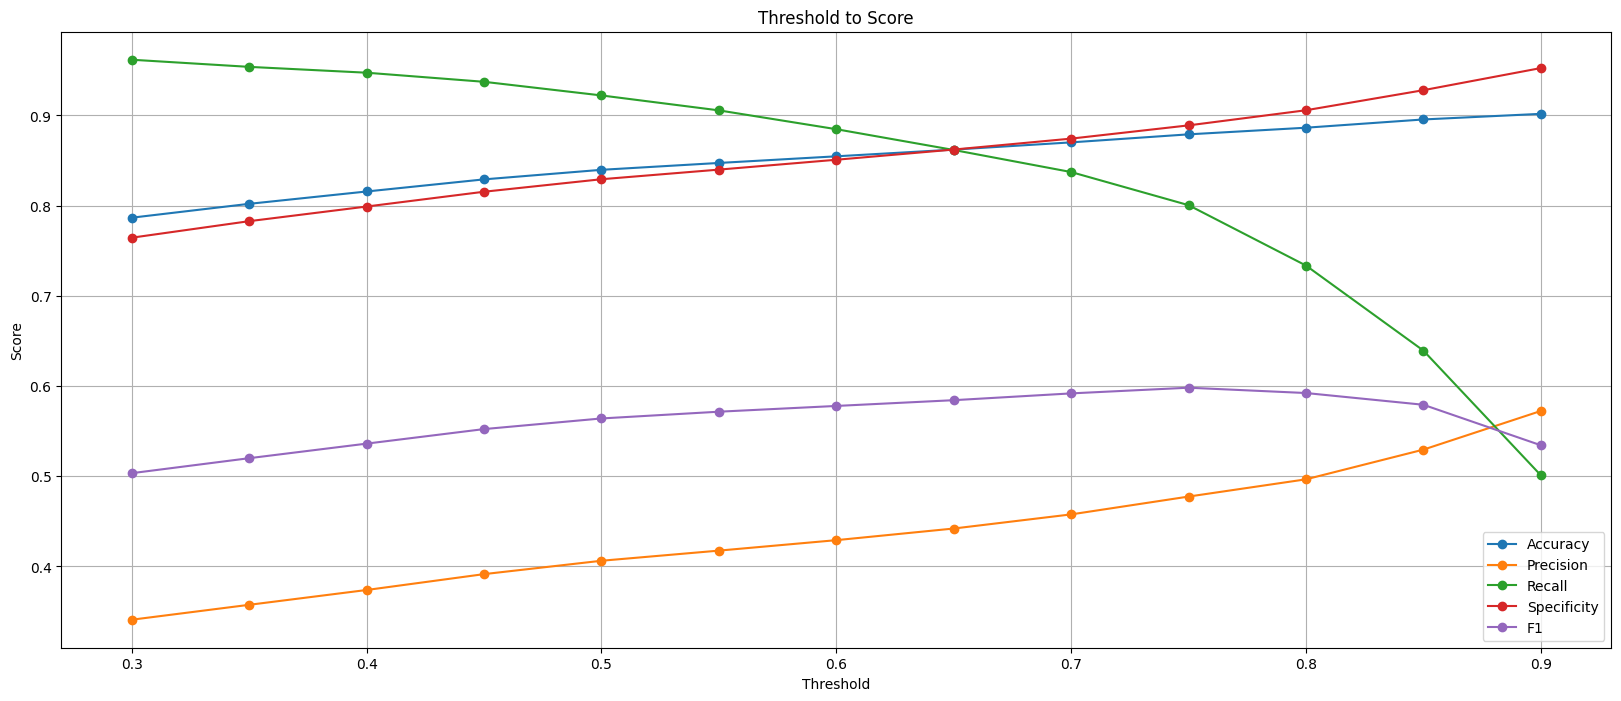

In [418]:
plot_model(cv3, X_test, y_test)

<div class="alert alert-block alert-warning">
At roughly 0.80 threshold, We see recall Score is more than 70%. F1 Score has settled at around 60%, Post 80%, we see decrease in Recall score more severe than Precision score increase
</div>

In [358]:
probs = cv3.predict_proba(X_test)
y_pred_3 = np.where(probs[:, 1] >= 0.80,  'yes','no')

## 7.4. Scoring

In [359]:
accuracy = accuracy_score(y_test, y_pred_3)
print("Accuracy:", accuracy)

Accuracy: 0.8864611151574007


In [360]:
p_score = precision_score(y_test, y_pred_3,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.496588693957115


In [361]:
r_score = recall_score(y_test, y_pred_3,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.7336213102951764


In [362]:
f_1_score = f1_score(y_test, y_pred_3, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.5922696890438826


In [363]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_3).ravel()
tn, fp, fn, tp

(np.int64(9935), np.int64(1033), np.int64(370), np.int64(1019))

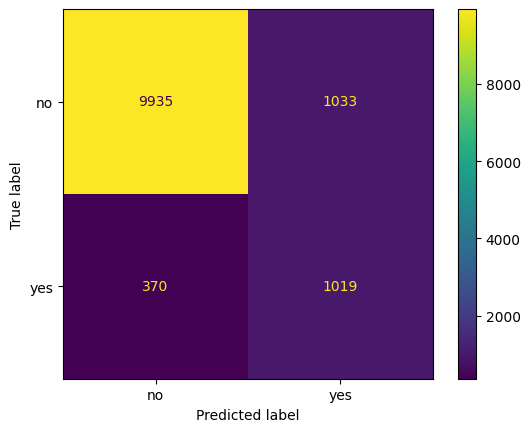

In [364]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_3);

<div class="alert alert-block alert-info">
    <b>Pipeline 4</b><br>
    - SMOTETomek was used resampling the minority class, as the dataset is unbalanced <br>
    - Followed by GridSearch and Feature Selection<br>
    - Weights are used with KNeighborsClassifier.        
</div>

# 8. Pipeline - 4

In [375]:
pipeline4 = IPipeline([
    ('transform', transformer), 
    ('SMOTET', SMOTETomek(sampling_strategy = 'minority', random_state=42)),
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(random_state=43, max_iter = 1000, C= 0.1, penalty= 'l1',solver= 'liblinear'))),
    ('model', KNeighborsClassifier(weights='distance'))
])

## 8.1 GridSearchCV

In [376]:
params4 = {
    'model__n_neighbors': list(range(11, 42, 2))
}

In [377]:
cv4 = GridSearchCV(pipeline4, param_grid=params4, n_jobs=-1, verbose=True, scoring=make_scorer(fbeta_score, beta=2, pos_label='yes'), error_score='raise')

## 8.2. Fitting the KNeighborsClassifier Model

In [378]:
cv4.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'university.degree',
                                                                                                     'profe...
                                        SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                                                     max_iter=1000,
                                                                                     penalty='l1',
                                                                                     random_state=43,
                                                                                     solver='liblinear'))),
                                       ('model',
                                        KNeighborsClassifier(weights='distance'))]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [11, 13, 15, 17, 19, 21, 23, 25,
                                                27, 29, 31, 33, 35, 37, 39,
                                                41]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2, pos_label=yes),
             verbose=True)

In [379]:
pprint(cv4.best_params_)

{'model__n_neighbors': 27}


## 8.3. Predictions

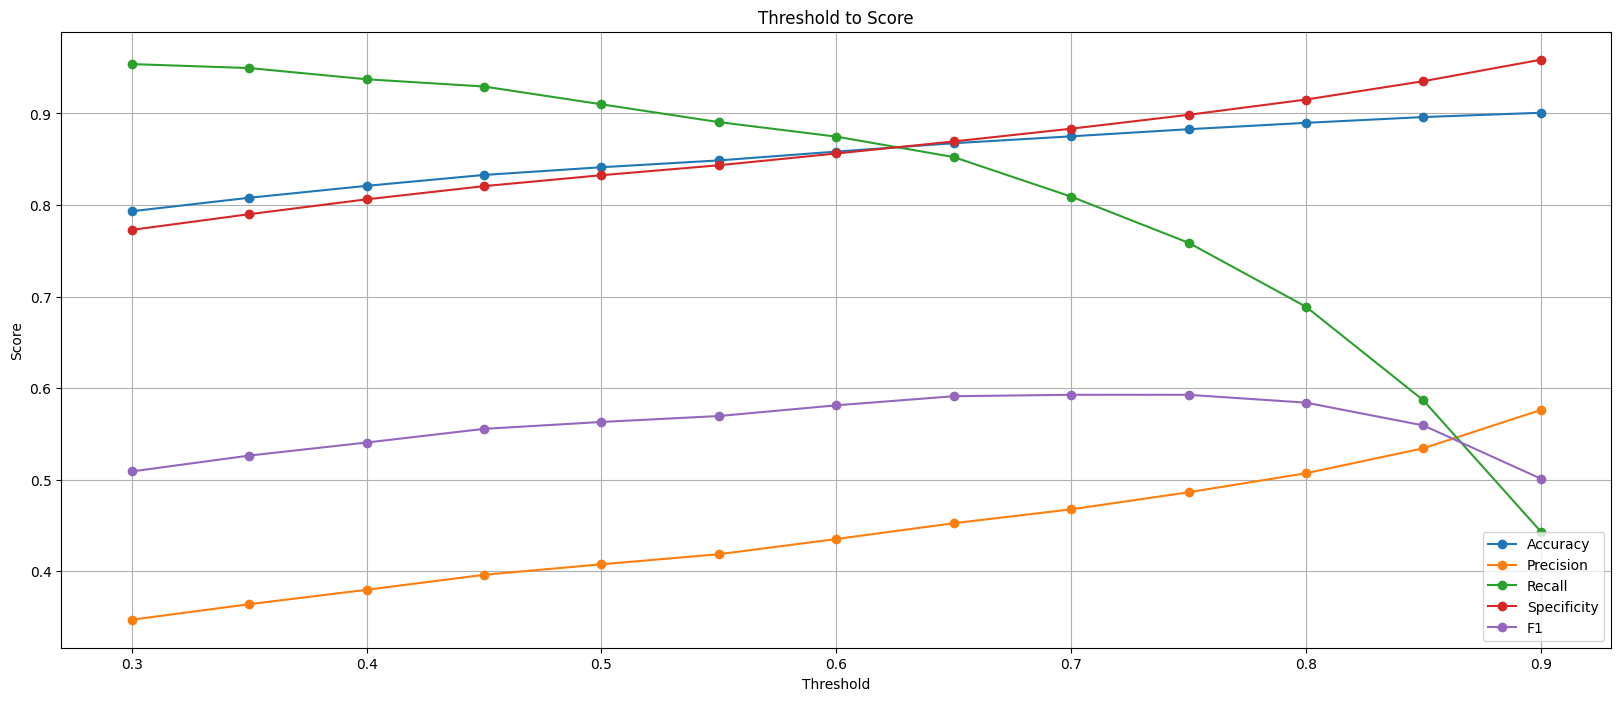

In [419]:
plot_model(cv4, X_test, y_test)

In [382]:
#y_pred_2 = cv2.predict(X_test)
probs = cv4.predict_proba(X_test)
y_pred_4 = np.where(probs[:, 1] >= 0.80,  'yes','no')

## 8.4. Scoring

In [383]:
accuracy = accuracy_score(y_test, y_pred_4)
print("Accuracy:", accuracy)

Accuracy: 0.8897790725904345


In [384]:
p_score = precision_score(y_test, y_pred_4,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.5071542130365659


In [385]:
r_score = recall_score(y_test, y_pred_4,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.6889848812095032


In [386]:
f_1_score = f1_score(y_test, y_pred_4, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.5842490842490843


In [387]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_4).ravel()
tn, fp, fn, tp

(np.int64(10038), np.int64(930), np.int64(432), np.int64(957))

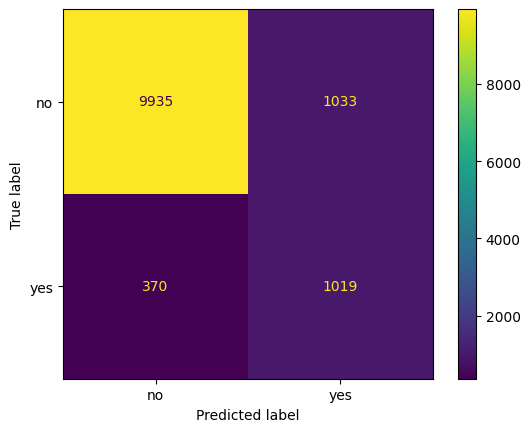

In [364]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_4);

<div class="alert alert-block alert-info">
    <b>Pipeline 5</b><br>
    - SMOTETomek was used resampling the minority class, as the dataset is unbalanced <br>
    - Followed by GridSearch and Feature Selection <br>
    - Weights are used with KNeighborsClassifier. <br>    
    - Pipeline is same as Pipeline4, but we have used `recall_score` to score.
</div>

# 9. Pipeline - 5

In [392]:
pipeline5 = IPipeline([
    ('transform', transformer), 
    ('SMOTET', SMOTETomek(sampling_strategy = 'minority', random_state=42)),
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(random_state=43, max_iter = 1000, C= 0.1, penalty= 'l1',solver= 'liblinear'))),
    ('model', KNeighborsClassifier(weights='distance'))
])

## 9.1 GridSearchCV

In [393]:
params5 = {
    'model__n_neighbors': list(range(11, 42, 2))
}

In [394]:
cv5 = GridSearchCV(pipeline5, param_grid=params5, n_jobs=-1, verbose=True, scoring=make_scorer(recall_score, pos_label='yes'), error_score='raise')

## 9.2. Fitting the KNeighborsClassifier Model

In [395]:
cv5.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'university.degree',
                                                                                                     'profe...
                                        SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                                                     max_iter=1000,
                                                                                     penalty='l1',
                                                                                     random_state=43,
                                                                                     solver='liblinear'))),
                                       ('model',
                                        KNeighborsClassifier(weights='distance'))]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [11, 13, 15, 17, 19, 21, 23, 25,
                                                27, 29, 31, 33, 35, 37, 39,
                                                41]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=yes),
             verbose=True)

In [396]:
pprint(cv5.best_params_)

{'model__n_neighbors': 41}


## 9.3. Predictions

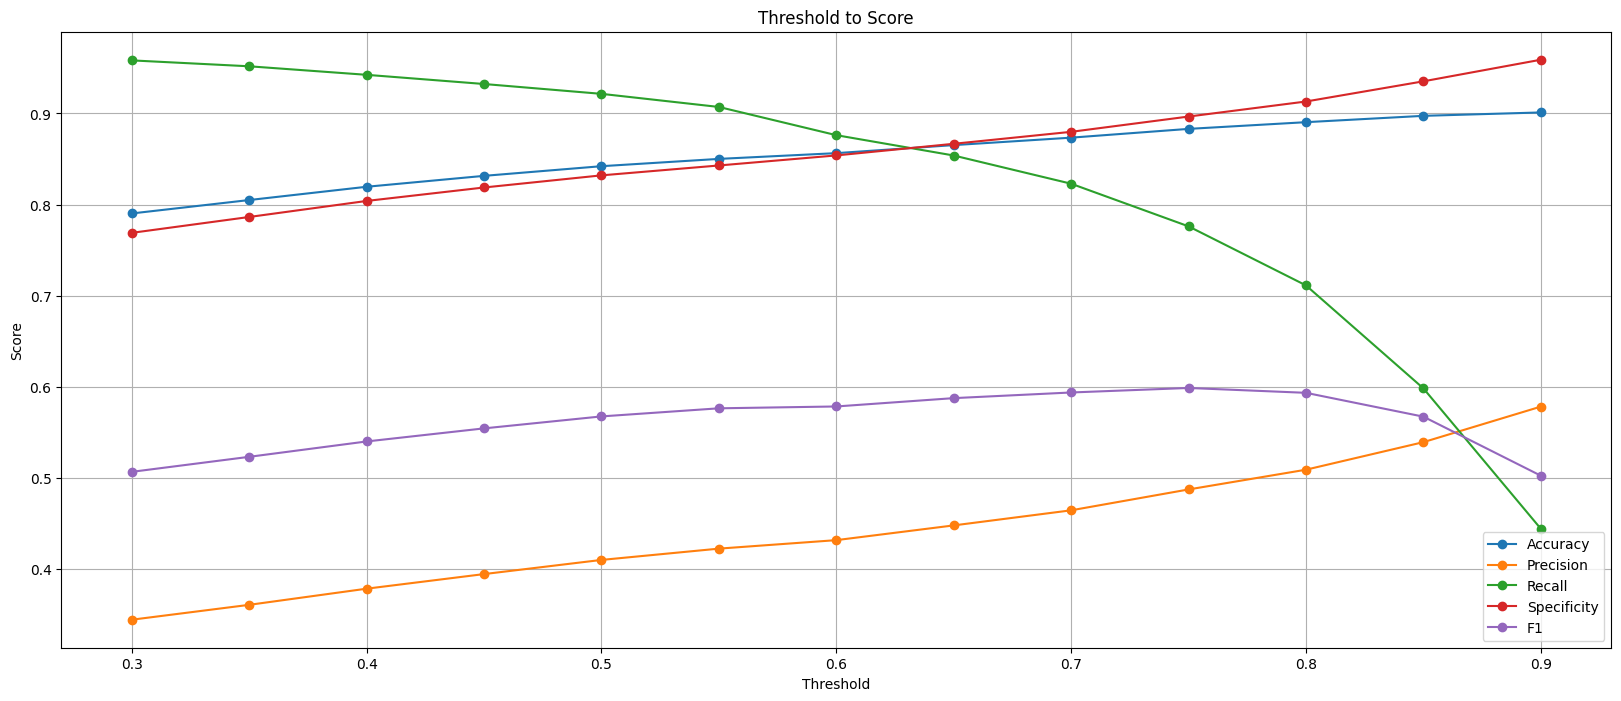

In [420]:
plot_model(cv5, X_test, y_test)

<div class="alert alert-block alert-warning">
At roughly 0.75 threshold, We see recall Score is around than 77%. F1 Score has settled at around 60%, 
</div>

In [398]:
#y_pred_2 = cv2.predict(X_test)
probs = cv5.predict_proba(X_test)
y_pred_5 = np.where(probs[:, 1] >= 0.75,  'yes','no')

## 9.4. Scoring

In [399]:
accuracy = accuracy_score(y_test, y_pred_5)
print("Accuracy:", accuracy)

Accuracy: 0.8830622319333171


In [400]:
p_score = precision_score(y_test, y_pred_5,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.4873417721518987


In [401]:
r_score = recall_score(y_test, y_pred_5,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.7760979121670266


In [402]:
f_1_score = f1_score(y_test, y_pred_5, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.5987225770619272


In [403]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_5).ravel()
tn, fp, fn, tp

(np.int64(9834), np.int64(1134), np.int64(311), np.int64(1078))

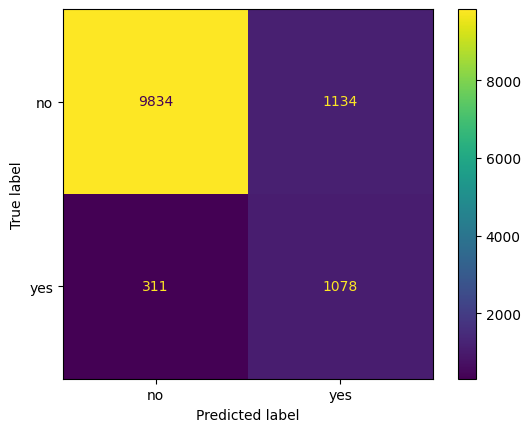

In [404]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_5);

<div class="alert alert-block alert-info">
    <b>Pipeline 6</b><br>
    - SMOTETomek was used resampling the minority class, as the dataset is unbalanced <br>
    - Followed by GridSearch and Feature Selection <br>
    - Weights are used with KNeighborsClassifier. <br>    
    - Pipeline is same as Pipeline4, but we have used `f1_score` to score.
</div>

# 10. Pipeline - 6

In [405]:
pipeline6 = IPipeline([
    ('transform', transformer), 
    ('SMOTET', SMOTETomek(sampling_strategy = 'minority', random_state=42)),
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(random_state=43, max_iter = 1000, C= 0.1, penalty= 'l1',solver= 'liblinear'))),
    ('model', KNeighborsClassifier(weights='distance'))
])

## 10.1 GridSearchCV

In [406]:
params6 = {
    'model__n_neighbors': list(range(11, 42, 2))
}

In [407]:
cv6 = GridSearchCV(pipeline6, param_grid=params6, n_jobs=-1, verbose=True, scoring=make_scorer(f1_score, pos_label='yes'), error_score='raise')

## 10.2. Fitting the KNeighborsClassifier Model

In [408]:
cv6.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'university.degree',
                                                                                                     'profe...
                                       ('feature_selection',
                                        SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                                                     max_iter=1000,
                                                                                     penalty='l1',
                                                                                     random_state=43,
                                                                                     solver='liblinear'))),
                                       ('model',
                                        KNeighborsClassifier(weights='distance'))]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [11, 13, 15, 17, 19, 21, 23, 25,
                                                27, 29, 31, 33, 35, 37, 39,
                                                41]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=yes),
             verbose=True)

In [411]:
pprint(cv6.best_params_)

{'model__n_neighbors': 27}


## 10.3. Predictions

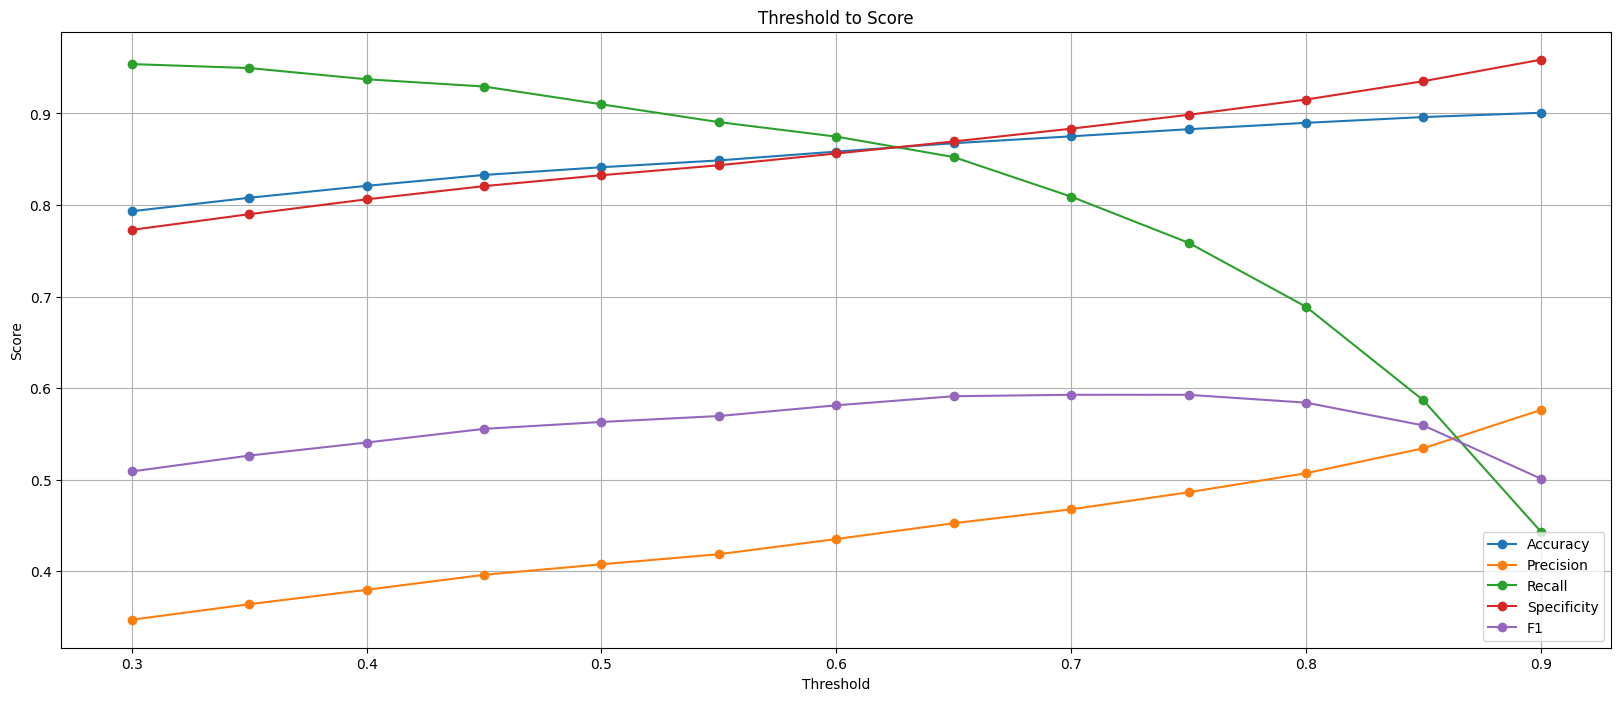

In [415]:
plot_model(cv6, X_test, y_test)

<div class="alert alert-block alert-warning">
At roughly 0.70 threshold, We see recall Score is more than 80%. F1 Score has settled at around 60%, Post 80%, we see decrease in Recall score more severe than Precision score increase
</div>

In [421]:
#y_pred_2 = cv2.predict(X_test)
probs = cv6.predict_proba(X_test)
y_pred_6 = np.where(probs[:, 1] >= 0.70,  'yes','no')

## 10.4. Scoring

In [427]:
accuracy = accuracy_score(y_test, y_pred_6)
print("Accuracy:", accuracy)

Accuracy: 0.875050578619406


In [428]:
p_score = precision_score(y_test, y_pred_6,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.4677486475239284


In [429]:
r_score = recall_score(y_test, y_pred_6,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.8092152627789777


In [430]:
f_1_score = f1_score(y_test, y_pred_6, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.5928270042194093


In [431]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_6).ravel()
tn, fp, fn, tp

(np.int64(9689), np.int64(1279), np.int64(265), np.int64(1124))

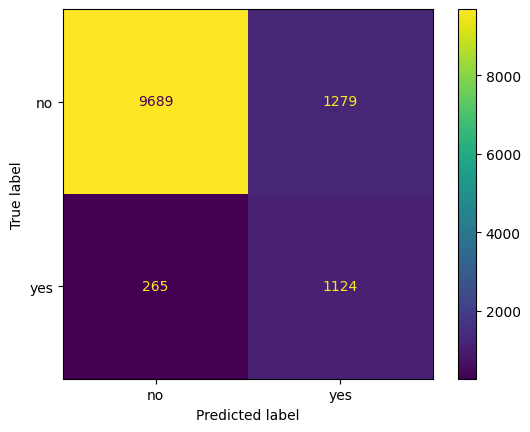

In [432]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_6);

<div class="alert alert-block alert-success">
    <h1>KNN Classification - Conclusion</h1>
</div>

|                           | Model 1     | Model 2     | Model 3     | Model 4     | Model 5      | Model 6    |
| :------------------------ | :---------- | :---------- | ----------- | ----------- | ------------ | ---------- |
| Metric                    | fbeta_score | fbeta_score | fbeta_score | fbeta_score | recall_score | f1_score   |
| Data Sampling Algorithms  | No          | No          | SMOTETomek  | SMOTETomek  | SMOTETomek   | SMOTETomek |
| Cost-Sensitive Algorithms | No          | No          | No          | Yes         | Yes          | Yes        |
| Feature Selection         | No          | Yes         | Yes         | Yes         | Yes          | Yes        |
| Threshold                 | 0.45        | 0.45        | 0.80        | 0.80        | 0.75         | 0.70       |
| Accuracy                  | 0.8991      | 0.9024      | 0.8864      | 0.8897      | 0.8830       | 0.8750     |
| Precision Score           | 0.5552      | 0.5691      | 0.4965      | 0.5071      | 0.4873       | 0.4677     |
| Recall Score              | 0.5176      | 0.5421      | 0.7336      | 0.6889      | 0.7760       | 0.8092     |
| F1 Score                  | 0.5357      | 0.5553      | 0.5922      | 0.5842      | 0.5987       | 0.5928     |

- The Best result for KNN Clasifier was **Model 6**, which helps us high recall_score, with marginal improvement in **F1 Score** with slight hit on **Precission Score**